In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
import multiprocessing
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from multi_process import slds_eigs_worker
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save

## Load Neural Data

In [3]:
# Mary - propofolPuffTone
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# Mr Jones - propofolPuffTone
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/MrJones-Anesthesia-20160121-01.mat'
# Mary - propofolWakeup
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolWakeup/Mary-Anesthesia-20170203-02.mat'
# Mary - propofolWakeup2
# filename = '/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolWakeup/Mary-Anesthesia-20161229-02.mat'
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo'], verbose=False)
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 159.50 seconds)


# Run

In [4]:
# --------
# User-guided SLDS parameters
# --------
latent_dim = 2 # number of latent dimensions
# transitions = "standard" # transition class
transitions = "standard"
stride = 5 # s
duration = 5 # s

length = int(duration/dt)
# start_times = np.arange(0, lfp.shape[0]*dt - duration + 0.1, stride).astype(int)
start_times = np.arange(0, lfp.shape[0]*dt - duration - 0.1, stride).astype(int)
start_times = np.hstack([start_times, lfp.shape[0]*dt - duration - 5])

# areas = ['vlPFC', 'FEF', 'CPB', '7b', 'Thal']
# areas = np.unique(electrode_info['area'])
areas = ['vlPFC']
unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
var_names = [f"unit_{unit_num} {electrode_info['area'][unit_num]}" for unit_num in unit_indices]

# --------
# Set the parameters of the SLDS
# --------
emissions_dim = len(unit_indices)     # number of observed dimensions

data_dir = "../../__data__/slds_dbs/"
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
data_dir = os.path.join(data_dir, f"slds_big_run_latent_{latent_dim}_duration_{duration}_stride_{stride}_{timestamp}")
os.makedirs(data_dir, exist_ok=True)

In [5]:
anesthesia_bounds = [session_info['drugStart'][0], session_info['drugEnd'][1]]
param_list = []
for start_time in start_times:

    # --------
    # Set Disc States for Each Segment
    # --------
    piece_bounds = [start_time, start_time + duration]
    if piece_bounds[1] <= anesthesia_bounds[0] or piece_bounds[0] >= anesthesia_bounds[1]:
        # WAKEFUL
        n_disc_states = 2
    elif piece_bounds[1] > anesthesia_bounds[0] and piece_bounds[1] <= anesthesia_bounds[1]:
        if piece_bounds[0] < anesthesia_bounds[0]:
            # TRANSITION TO ANESTHESIA
            n_disc_states = 2
        else: # piece_bounds[0] >= anesthesia_bounds
            # FULL ANESTHESIA
            n_disc_states = 2
    else: # piece_bounds[0] > anesthesia_bounds[1] and piece_bounds[1] > anesthesia_bounds[1]
        # TRANSITION OUT OF ANESTHESIA
        n_disc_states = 2

    start_step = int(start_time/dt)
    data = lfp[start_step:start_step + length, unit_indices]
    param_list.append((start_time, start_step, data, transitions, emissions_dim, n_disc_states, latent_dim, data_dir))

In [6]:
for param_tuple in tqdm(param_list):
    slds_eigs_worker(param_tuple, savefile=True, verbose=False)

  0%|          | 0/2077 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Analyze

In [11]:
%%time
# run_params = load(os.path.join(data_dir, "run_params"))
results_files = [f for f in os.listdir(data_dir) if f.startswith('start_time')]
results = []
for file in results_files:
    results.append(load(os.path.join(data_dir, file)))
results = sorted(results, key=lambda d: d['start_time'])
results = pd.DataFrame(results)

CPU times: user 649 ms, sys: 3.46 s, total: 4.11 s
Wall time: 6.57 s


In [12]:
duration = 5
stride = 5
latent_dim = 2

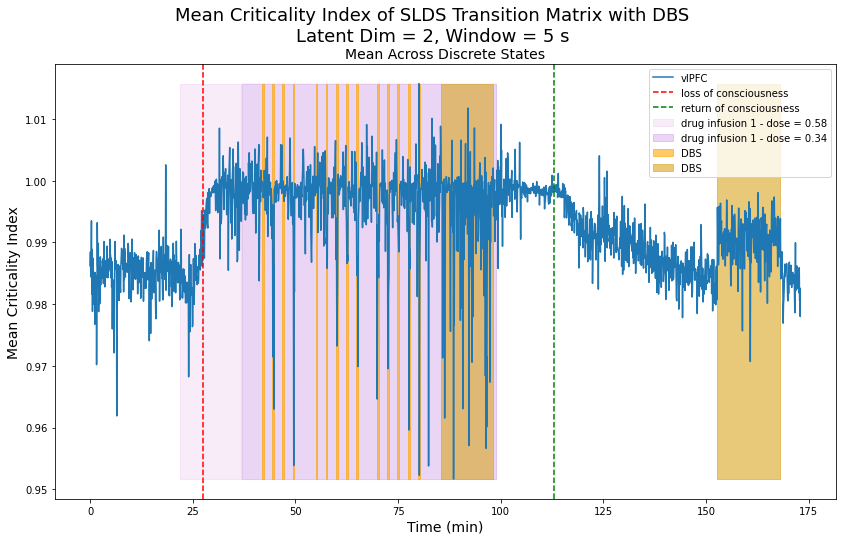

In [55]:
fig = plt.figure(figsize=(14, 8))

ax = plt.gca()
start_times = results.start_time/60
mean_eigs = np.array([mat.mean() for mat in results.criticality_inds])
ax.plot(start_times, mean_eigs, label='vlPFC')
ax.set_xlabel('Time (min)', fontsize=14)
ax.set_ylabel('Mean Criticality Index', fontsize=14)
ax.set_title("Mean Across Discrete States", fontsize=14)
min_val = mean_eigs.min()
max_val = mean_eigs.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                        min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")

if np.sum(session_info['eyesOpen']) < 10:
        plt.axvline(session_info['eyesClose'][0]/60, linestyle='--', c='red', label="loss of consciousness")
        plt.axvline(session_info['eyesClose'][1]/60, linestyle='--', c='green', label="return of consciousness")
else:
    plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
    plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")

dbs_bool =  {'train': np.zeros(len(mean_eigs)), 'pulse': np.zeros(len(mean_eigs))}
for i, (t_on, t_off, timing_type) in enumerate(zip(trial_info['dbs_stimOn'], trial_info['dbs_stimOff'], trial_info['dbs_timingType'])):
    dbs_bool[timing_type][int(t_on/stride):int(t_off/stride)] = 1

for timing_type, c in [('train', 'orange'), ('pulse', 'goldenrod')]:
    ax.fill_between(start_times, min_val, max_val, where=dbs_bool[timing_type], color=c, alpha=0.6, label='DBS')


    
ax.legend()
plt.suptitle(f"Mean Criticality Index of SLDS Transition Matrix with DBS\nLatent Dim = {latent_dim}, Window = {duration} s", fontsize=18)
plt.show()

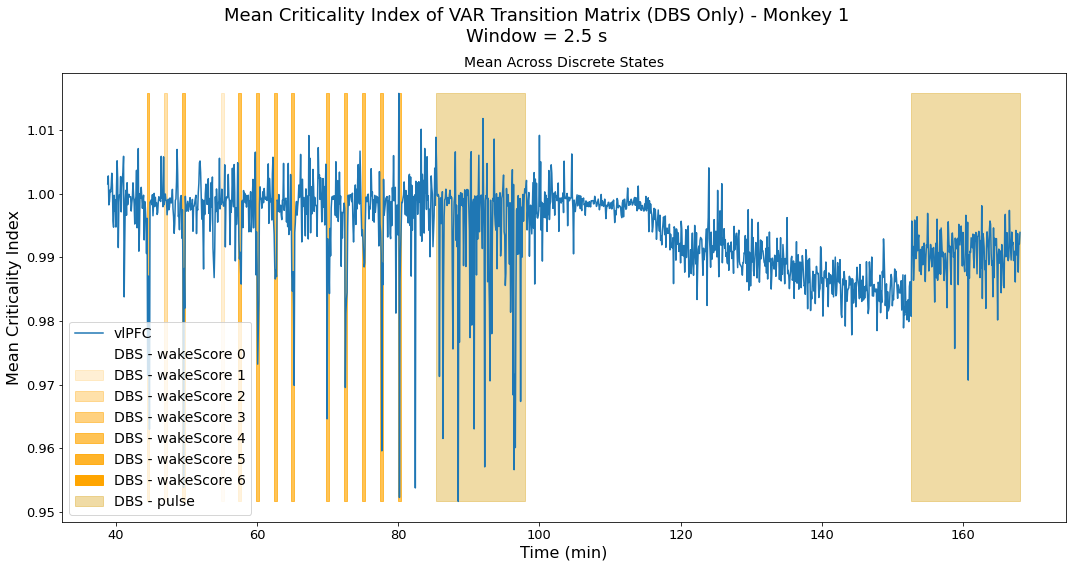

In [54]:
fig = plt.figure(figsize=(15, 8))

min_val = np.Inf
max_val = -np.Inf
# start_ind = np.max([int((trial_info['dbs_stimOn'][0] - 180)/stride), 0])
# end_ind = int(([t for t, typ in zip(trial_info['dbs_stimOff'], trial_info['dbs_timingType']) if typ == 'train'][-1] + 180)/stride)

start_ind = np.max([int((trial_info['dbs_stimOn'][0] - 180)/stride), 0])
end_ind = int(([t for t, typ in zip(trial_info['dbs_stimOff'], trial_info['dbs_timingType'])][-1])/stride)

areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]

start_times = results.start_time[start_ind:end_ind]/60
# for area, c in areas_colors:
for area, c in [('vlPFC', 'C0')]:
    mean_eigs = np.array([mat.mean() for mat in results.criticality_inds])[start_ind:end_ind]
    plt.plot(start_times, mean_eigs, label=area, c=c)

    plt.xlabel('Time (min)', fontsize=14)
    plt.ylabel('Mean Criticality Index', fontsize=14)
    plt.title("Mean Across Discrete States", fontsize=14)
    if mean_eigs.min() < min_val:
        min_val = mean_eigs.min()
    if mean_eigs.max() > max_val:
        max_val = mean_eigs.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()

dbs_bool = np.zeros((8, len(mean_eigs)))
for i, (t_on, t_off, timing_type, score) in enumerate(zip(trial_info['dbs_stimOn'], trial_info['dbs_stimOff'], trial_info['dbs_timingType'], trial_info['dbs_wakeScore'])):
#     if timing_type == 'train' and not np.isnan(score):
#         score = int(score)
#         dbs_bool[score, int(t_on/stride) - start_ind:int(t_off/stride) - start_ind] = 1
    if np.isnan(score):
        score = 7
    score = int(score)
    dbs_bool[score, int(t_on/stride) - start_ind:int(t_off/stride) - start_ind] = 1

for score in range(7):
    plt.fill_between(start_times, min_val, max_val, where=dbs_bool[score], color='orange', alpha=score/6, label=f'DBS - wakeScore {score}')
plt.fill_between(start_times, min_val, max_val, where=dbs_bool[7], color='goldenrod', alpha=0.4, label=f'DBS - pulse')
plt.legend(fontsize=14)        
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Mean Criticality Index', fontsize=16)
plt.tick_params(labelsize=13)
plt.suptitle("Mean Criticality Index of VAR Transition Matrix (DBS Only) - Monkey 1\nWindow = 2.5 s", fontsize=18)
plt.tight_layout()
plt.show()